In [1]:
# sys packages
import os
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append('../src')

# data manipulation
import pandas as pd
import numpy as np
import imblearn

# sckit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

from sklearn import tree



from optbinning import OptimalBinning, OptimalPWBinning, BinningProcess

# Viz packages
import matplotlib.pyplot as plt

import utils

%matplotlib inline


In [2]:
# MACRO VARIABLES

INPUT_DIR = '../inputs/'

INPUT_DATA = 'dados.csv'

# Out of time length in days
OFT_LEN = 7

# Train Test Size

TRAIN_TEST_LEN = 0.3

# RANDOM STATE
SEED = 395

YNAME = 'fraude'

#### Import Data

In [3]:
original_df = pd.read_csv(os.path.join(INPUT_DIR, INPUT_DATA), decimal='.')
original_df.head()


,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,fecha,monto,score,fraude
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1,NaN,N,2020-03-27 11:51:16,5.64,66,0
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,2020-04-15 19:58:08,124.71,72,0
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1,NaN,N,2020-03-25 18:13:38,339.32,95,0
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,NaN,Y,2020-04-16 16:03:10,3.54,2,0
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1,NaN,N,2020-04-02 10:24:45,3.53,76,0


#### Train, Test and Out-Of-Time samples

In [4]:
# It seems that 'fecha' is the date that the operation occured, so I'll use it to create a out-of-time sample
# First it needed to be converted to a date format
df = original_df.copy()

df['oper_date'] = pd.to_datetime(df['fecha'])

# Year-Month
df['oper_YM'] = df['oper_date'].apply(lambda x: x.year * 100 + x.month )

# Year-Month-Day
df['oper_YMD'] = df['oper_date'].apply(lambda x: (x.year * 100 + x.month)*100 + x.day  )


In [5]:
check_YM_dist = df.groupby('oper_YM').agg(qt=('fecha', len))
check_YM_dist

# The data has only a sample of 2 months, so its not gonna be a good choice to split a out-of time sample based on month 

,qt
oper_YM,
202003,76961
202004,73039


<AxesSubplot:xlabel='oper_YMD'>

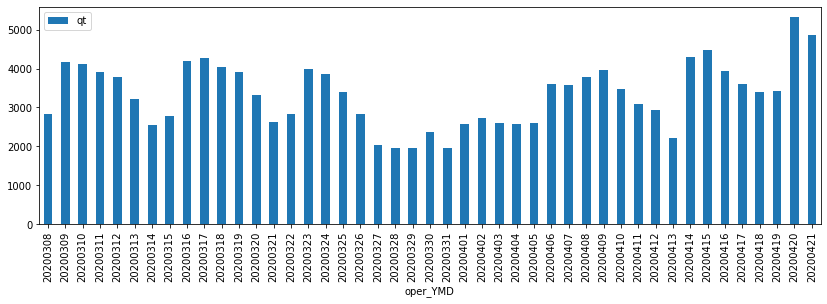

In [6]:
check_YMD_dist = df.groupby('oper_YMD').agg(qt=('fecha', len))
check_YMD_dist.plot(kind='bar', figsize=(14,4))

# The out-of-sample will be of 7 days(1 week), it ill be set on macro variables cell.

In [7]:
# Split out of time sample

__OutOfTimeMax__ = df['oper_date'].max()
__OutOfTimeMin__ = __OutOfTimeMax__ + pd.offsets.DateOffset(days=-OFT_LEN)

# This is the dataset tha will be used to evaluate the model
outoftime = df.loc[df['oper_date'] >= __OutOfTimeMin__, :]

In [8]:
# Create y and X

traintest = df.loc[df['oper_date'] < __OutOfTimeMin__, :]

y =  traintest[YNAME]

__colstodrop__ = ['fecha', 'monto', 'score', 'fraude', 'oper_YM', 'oper_YMD']
X = traintest.drop(columns=__colstodrop__)


In [9]:
# Split in train test samples

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TRAIN_TEST_LEN, random_state=SEED)


#### Model Development

The next steps will be done only with Train Set and later on will be test in the Test Set and Out of Time Sets

#### New Feature

After a quick search on the internet, I get that the majority of frauds used are done beteween 1h and 5h am
I will create a new feature with the hour that the operation was finished to test if has a good discrimination

In [10]:
X_train['hora'] = X_train['oper_date'].apply(lambda x: x.hour)
X_train.drop(columns=['oper_date'], inplace=True)

#### Univariate Analysis

It's commom to observe imbalanced dataset for fraud detection problems.
If it's not handle properly it could result in a misleading model, where the accuracy is high because is more likely that the model will classify all events as a non-fraud.
In a model lije that will be a great amount of losses.

In [11]:
print('fraud_rate {:.3%}'.format(y_train.sum() / len(y_train)))

# With this rate I've opted for oversampling

# Initialize a object for oversampling with default distribution  of minority class
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority', random_state=SEED)

# Fit Oversample
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train)

print(' New fraud_rate {:.3%}'.format(y_train_OS.sum() / len(y_train_OS)))

fraud_rate 5.145%
 New fraud_rate 50.000%


#### Handle Missing

<AxesSubplot:>

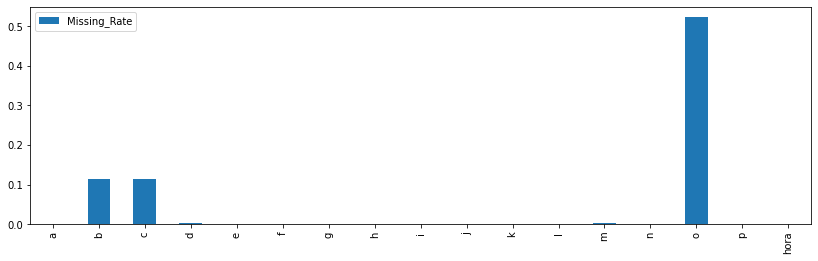

In [12]:
# Handle Missing Data
missing_freq = pd.DataFrame(X_train_OS.isna().sum() / X_train_OS.isna().count(), columns='Missing_Rate'.split())
missing_freq.plot(kind='bar', figsize=(14,4))

# Missing data will be replaced by a different category in each variable
# I haven't chosen to replace misssing by the mean/meadian of the variable, because in most cases, creating another category for the missing date has more 4explaining power.
# Column 'o' has more than 50% of its observation missing, maybe its a good choice to remove from the model

In [13]:
# replace missing data with -999 category
X_train_OS = utils.replace_missing(X_train_OS)
X_train_OS.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,hora
0,4,0.7619,88723.38,2.0,0.161483,1.0,BR,16,Trava Tranca Eletrica Tampa Caçamba L200 Trito...,cat_d05132a,0.582140,643.0,191.0,0,-999,N,22
1,3,0.6320,2265.07,31.0,0.056948,14.0,AR,4,Mesa Comedor De Mármol Moderna De Diseño - Car...,cat_af842b7,0.023867,4871.0,134.0,1,-999,Y,18
2,4,0.8255,1272.96,29.0,0.000000,12.0,BR,22,Trocador Lençol Absorvente Descartável Mili L...,cat_0722d79,0.473002,4882.0,37.0,1,-999,N,1
3,4,0.6513,24235.66,42.0,0.000000,1.0,BR,2,Tela Touch Frontal Display J4 Plus J4 Core J6 ...,cat_237e2d0,0.879633,409.0,142.0,1,N,Y,22
4,4,0.7636,78081.00,6.0,0.000000,0.0,BR,4,Kit Retrovisor Automotivo Lcd E Câmera De Ré C...,cat_f597e16,0.518003,29.0,15.0,0,-999,N,17


#### Variable distribution

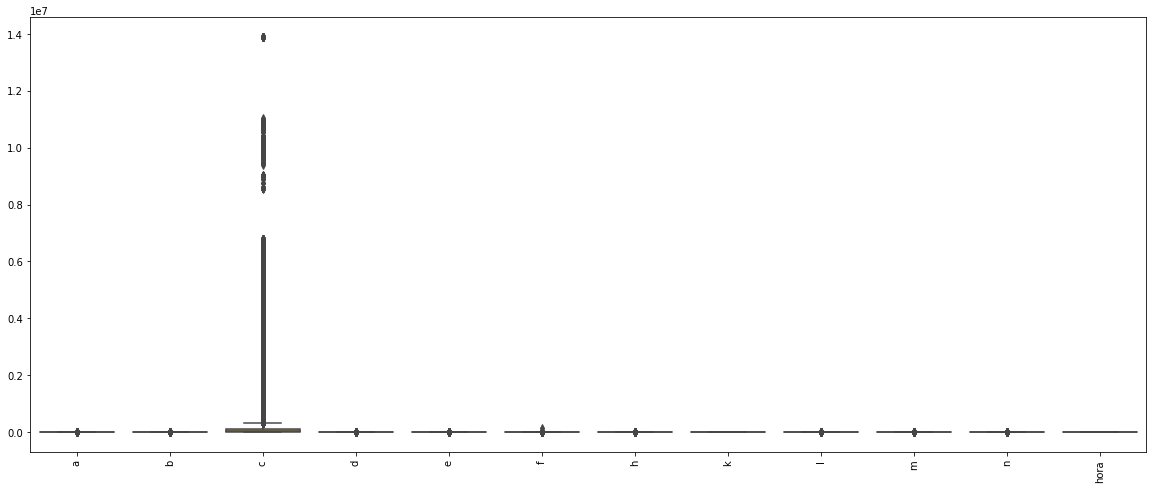

In [14]:

# Boxplot for numerical columns
fig, ax = plt.subplots(figsize=(20,8))
boxplot = sns.boxplot(data=X_train_OS)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

plt.show()

# columns 'c' has a lot of outliers 
# I will test some categorization for numeric data to get a better performance of the model and avoid noise, but maybe its a good choice to remove column 'c' from de model.

----------------------------------------
g



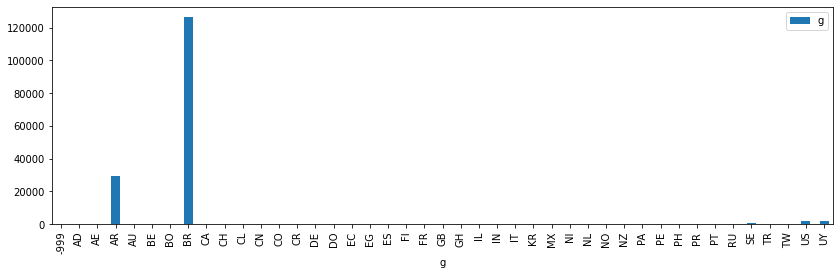

----------------------------------------
i

i has more than 50 categories and will not be ploted
----------------------------------------
j

j has more than 50 categories and will not be ploted
----------------------------------------
o



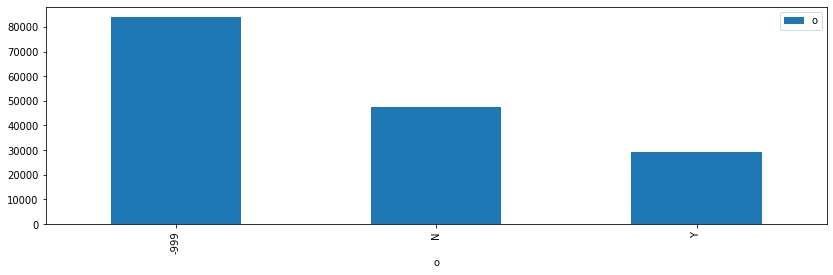

----------------------------------------
p



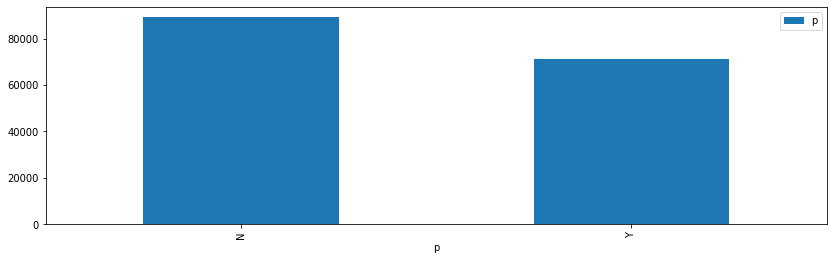

In [15]:
# Bar Plot for numerical columns
for col in X_train_OS.columns:
    if X_train_OS[col].dtype == 'O':
        
        print('-'*40)
        print(col)
        print()
        
        __QtdCat__ = len(X_train_OS[col].unique())

        if __QtdCat__ <= 50:

            gpd = X_train_OS.groupby(col).agg({col:'count'})
            plot_gpd = gpd.plot(kind='bar', figsize=(14,4))
            plt.show()

        else:
            print(col, 'has more than 50 categories and will not be ploted')

    else:
       pass

# Column 'g' is heavy concentrated in BR and AR so in futher analysis maybe i will split then in subgroups
# Column 'o' have a lot of missings
# Columns 'i' and 'j' are too granular


I will have some insight of the data

* First i will do a feature selection with gradient boosting to know what variables are more important (with the raw variables)
* Second i will bin the variables and get a ordered relationship with the response variable
* Then I will do a final feature selection

In [16]:

# Enconder for categorical date

__FTypes__ = X_train_OS.dtypes
FToTransf = __FTypes__[(__FTypes__ == np.int64) | (__FTypes__ == np.object) ].index.to_list()
print(FToTransf)

# Encoder obj

label_encoder = ColumnTransformer([('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-999), FToTransf)], remainder='drop')

# Fit Transform
X_train_OS_LE = utils.encode_df(label_encoder, X_train_OS, FToTransf,'fit_transform')

X_train_OS_LE.head()

['a', 'g', 'h', 'i', 'j', 'n', 'o', 'p', 'hora']


,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,hora
0,3.0,0.7619,88723.38,2.0,0.161483,1.0,7.0,16.0,71604.0,5799.0,0.582140,643.0,191.0,0.0,0.0,0.0,22.0
1,2.0,0.6320,2265.07,31.0,0.056948,14.0,3.0,4.0,48761.0,4894.0,0.023867,4871.0,134.0,1.0,0.0,1.0,18.0
2,3.0,0.8255,1272.96,29.0,0.000000,12.0,7.0,22.0,71827.0,196.0,0.473002,4882.0,37.0,1.0,0.0,0.0,1.0
3,3.0,0.6513,24235.66,42.0,0.000000,1.0,7.0,2.0,69645.0,1002.0,0.879633,409.0,142.0,1.0,1.0,1.0,22.0
4,3.0,0.7636,78081.00,6.0,0.000000,0.0,7.0,4.0,42995.0,6802.0,0.518003,29.0,15.0,0.0,0.0,0.0,17.0


In [17]:
%%time
# Fit a Gboosting to get insights on which features are the most important
# this is not the final model
gboosting = GradientBoostingClassifier(random_state=SEED).fit(X_train_OS_LE, y_train_OS)

CPU times: total: 33.3 s
Wall time: 33.3 s


In [18]:
# Feature Importance

fi = pd.DataFrame({'Columns': X_train_OS_LE.columns, 
                   'Feature_importance': gboosting.feature_importances_})
#sort values
fi.sort_values('Feature_importance', ascending=False, inplace=True)

# fi.drop(columns=['index'], inplace=True)

fi

# Variable 'o' has a higher feature importante 
# Other columns are not so good

,Columns,Feature_importance
14,o,0.593711
13,n,0.065506
5,f,0.064496
12,m,0.062567
11,l,0.057375
16,hora,0.023310
1,b,0.023136
7,h,0.018426
2,c,0.018030
6,g,0.017903


---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.09523217
    IV (Jeffrey)             0.06029833
    JS (Jensen-Shannon)      0.00746937
    Hellinger                0.00750311
    Triangular               0.02961278
    KS                       0.09523217
    HHI                      0.69374152
    HHI (normalized)         0.59165536
    Cramer's V               0.12168152
    Quality score            0.10139800

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]     P[B > A]
        0      1  2379.416775      0.0       1.0 1.110223e-16



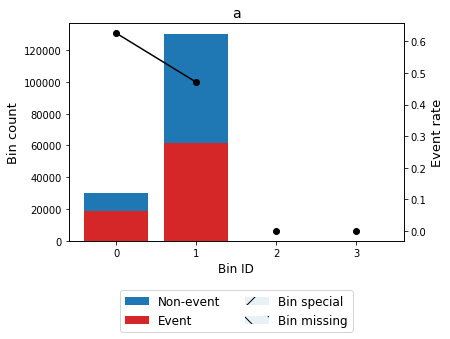

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.14832685
    IV (Jeffrey)             0.10751048
    JS (Jensen-Shannon)      0.01298745
    Hellinger                0.01320626
    Triangular               0.05034669
    KS                       0.09136165
    HHI                      0.20537598
    HHI (normalized)         0.11708442
    Cramer's V               0.15866111
    Quality score            0.38113784

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]     P[B > A]
        0      1   255.004692 2.105784e-57  1.000000e+00 1.110223e-16
        1      2    54.424340 1.615495e-13  1.000000e+00 1.110223e-16
        2      3    44.789628 2.193817e-11  2.296215e-12 1.000000e+00
        3      4    33.659470 6.565449e-09  1.437735e-09 1.000000e+00
        4      5   137.74181

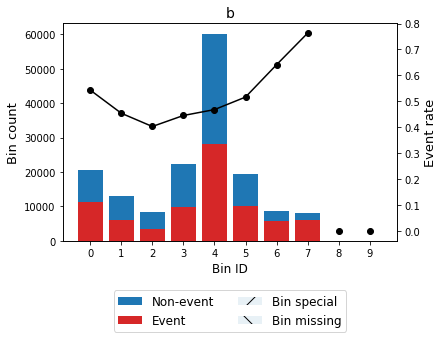

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.13490535
    IV (Jeffrey)             0.06475907
    JS (Jensen-Shannon)      0.00804938
    Hellinger                0.00807204
    Triangular               0.03201849
    KS                       0.06269990
    HHI                      0.14080783
    HHI (normalized)         0.05488861
    Cramer's V               0.12652764
    Quality score            0.24087298

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]     P[B > A]
        0      1   392.686118 2.153333e-87 1.000000e+00 1.110223e-16
        1      2    13.877881 1.950809e-04 9.999083e-01 9.169919e-05
        2      3    40.628666 1.840861e-10 1.000000e+00 1.110223e-16
        3      4    22.437801 2.170597e-06 3.846764e-07 9.999996e-01
        4      5    30.071290 4.1

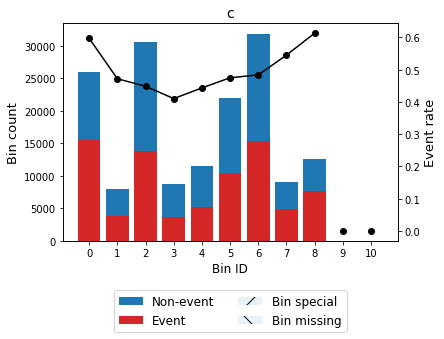

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.23679006
    IV (Jeffrey)             0.18371920
    JS (Jensen-Shannon)      0.02262170
    Hellinger                0.02279166
    Triangular               0.08916513
    KS                       0.17119886
    HHI                      0.18010219
    HHI (normalized)         0.06297393
    Cramer's V               0.21114583
    Quality score            0.64393864

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]     P[B > A]
        0      1   479.537825 2.693470e-106       1.0 1.110223e-16
        1      2    25.351665  4.777398e-07       1.0 9.317821e-08
        2      3    26.991651  2.043362e-07       1.0 7.094034e-09
        3      4   144.592194  2.637050e-33       1.0 1.110223e-16
        4      5   561.111858 4.816738e-124

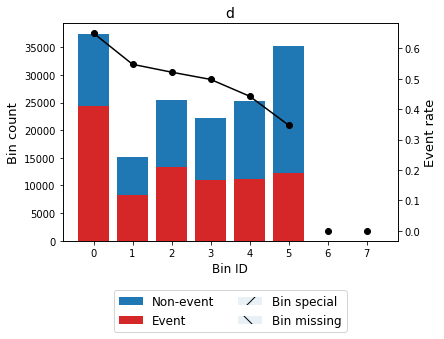

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.09537507
    IV (Jeffrey)             0.03246228
    JS (Jensen-Shannon)      0.00404849
    Hellinger                0.00405313
    Triangular               0.01615711
    KS                       0.07882914
    HHI                      0.30145368
    HHI (normalized)         0.21413539
    Cramer's V               0.08988078
    Quality score            0.10309601

  Monotonic trend       valley (convex)

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]     P[B > A]
        0      1   178.754759 9.063836e-41 1.000000e+00 1.110223e-16
        1      2    48.604976 3.130739e-12 1.000000e+00 1.110223e-15
        2      3    17.492334 2.884684e-05 9.999980e-01 1.961996e-06
        3      4     4.912345 2.666541e-02 1.295817e-02 9.870418e-01
        4      5    17.583269 2.7

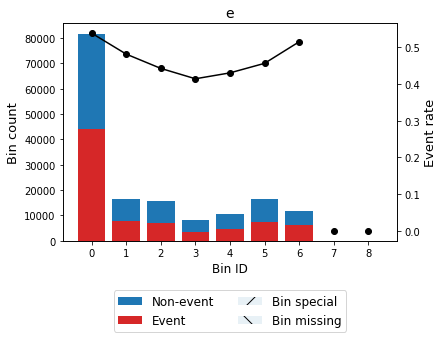

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.36171905
    IV (Jeffrey)             0.43622722
    JS (Jensen-Shannon)      0.05283614
    Hellinger                0.05366531
    Triangular               0.20509000
    KS                       0.27332578
    HHI                      0.15557034
    HHI (normalized)         0.07112737
    Cramer's V               0.32022648
    Quality score            0.71901998

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]     P[B > A]
        0      1  1021.053028 4.765887e-224  1.000000 1.110223e-16
        1      2    65.888562  4.771528e-16  1.000000 1.110223e-16
        2      3     1.545389  2.138174e-01  0.893344 1.066559e-01
        3      4   102.577102  4.149013e-24  1.000000 1.110223e-16
        4      5   243.813859  5.796166e-55

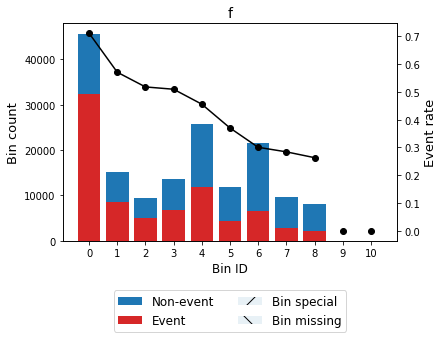

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.05222088
    IV (Jeffrey)             0.01837489
    JS (Jensen-Shannon)      0.00229032
    Hellinger                0.00229359
    Triangular               0.00913535
    KS                       0.05222088
    HHI                      0.70148698
    HHI (normalized)         0.60198264
    Cramer's V               0.06758457
    Quality score            0.03043667

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
        0      1   734.034376 1.188373e-161 1.573920e-184       1.0



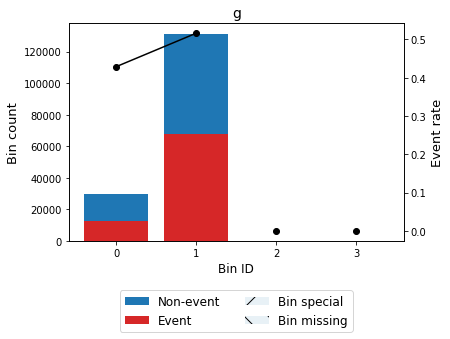

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.13157376
    IV (Jeffrey)             0.07223996
    JS (Jensen-Shannon)      0.00890801
    Hellinger                0.00896838
    Triangular               0.03516353
    KS                       0.09317868
    HHI                      0.20966353
    HHI (normalized)         0.11087147
    Cramer's V               0.13259625
    Quality score            0.15034387

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]     P[B > A]
        0      1   657.716355 4.687822e-145  1.000000 1.110223e-16
        1      2     0.639488  4.238961e-01  0.788248 2.117522e-01
        2      3    90.172487  2.182764e-21  1.000000 1.110223e-16
        3      4    78.559557  7.762239e-19  1.000000 1.110223e-16
        4      5    12.174849  4.843821e-04

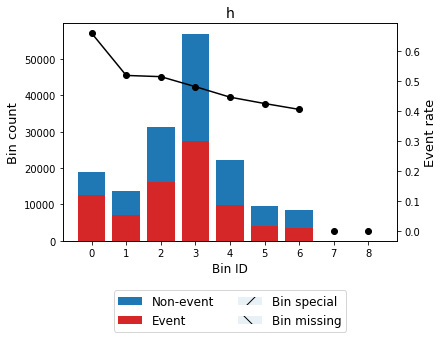

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.05009112
    IV (Jeffrey)             0.01542998
    JS (Jensen-Shannon)      0.00191998
    Hellinger                0.00192435
    Triangular               0.00764534
    KS                       0.03637789
    HHI                      0.53915927
    HHI (normalized)         0.46235248
    Cramer's V               0.06182773
    Quality score            0.02549365

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1    52.255195 4.873685e-13 2.133225e-17  1.000000
        1      2     1.259094 2.618227e-01 1.307786e-01  0.869221
        2      3    82.517184 1.047555e-19 3.544957e-77  1.000000
        3      4   109.524204 1.245741e-25 1.579592e-48  1.000000



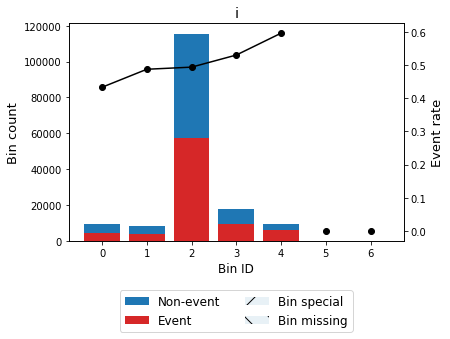

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.07050368
    IV (Jeffrey)             0.01756558
    JS (Jensen-Shannon)      0.00219172
    Hellinger                0.00219370
    Triangular               0.00875106
    KS                       0.03198467
    HHI                      0.25704507
    HHI (normalized)         0.13321925
    Cramer's V               0.06614780
    Quality score            0.01977104

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic      p-value      P[A > B]     P[B > A]
        0      1   210.977764 8.405193e-48  1.000000e+00 1.110223e-16
        1      2     0.161253 6.880054e-01  6.560359e-01 3.439641e-01
        2      3    73.183080 1.181644e-17  1.000000e+00 1.110223e-16
        3      4   424.169483 3.019392e-94 8.302762e-119 1.000000e+00



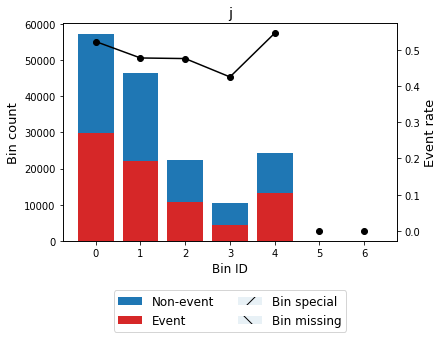

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.02981228
    IV (Jeffrey)             0.00464247
    JS (Jensen-Shannon)      0.00057966
    Hellinger                0.00057998
    Triangular               0.00231606
    KS                       0.02032333
    HHI                      0.25006886
    HHI (normalized)         0.14293584
    Cramer's V               0.03402982
    Quality score            0.01150640

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]     P[B > A]
        0      1     1.918869 1.659814e-01 9.172207e-01 8.277932e-02
        1      2    90.940711 1.480422e-21 1.000000e+00 1.110223e-16
        2      3     8.595360 3.370205e-03 1.404704e-03 9.985953e-01
        3      4    34.922247 3.431376e-09 7.472352e-10 1.000000e+00
        4      5     1.929063 1.6

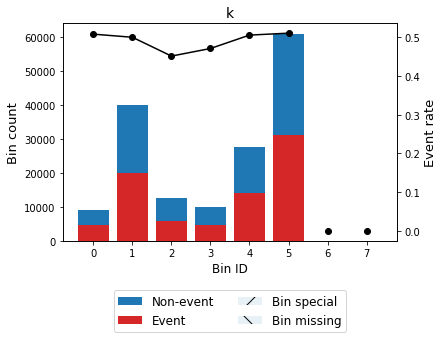

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.34188126
    IV (Jeffrey)             0.43979336
    JS (Jensen-Shannon)      0.05132352
    Hellinger                0.05303287
    Triangular               0.19379880
    KS                       0.24594591
    HHI                      0.08534594
    HHI (normalized)         0.02001351
    Cramer's V               0.31128668
    Quality score            0.69991945

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value  P[A > B]     P[B > A]
        0      1   428.000064 4.427680e-95  1.000000 1.110223e-16
        1      2   262.020615 6.224103e-59  1.000000 1.110223e-16
        2      3    50.102841 1.458956e-12  1.000000 8.881784e-16
        3      4    21.249384 4.032399e-06  0.999999 9.960349e-07
        4      5    65.434713 6.007142e-16  1.00

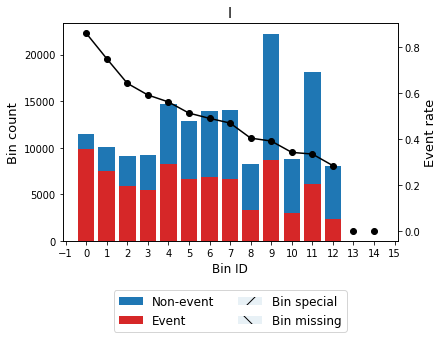

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.32650662
    IV (Jeffrey)             0.35640964
    JS (Jensen-Shannon)      0.04322282
    Hellinger                0.04387368
    Triangular               0.16798168
    KS                       0.23602693
    HHI                      0.13376154
    HHI (normalized)         0.04713769
    Cramer's V               0.28981173
    Quality score            0.86590513

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value  P[A > B]     P[B > A]
        0      1   359.023794 4.593576e-80  1.000000 1.110223e-16
        1      2   307.424339 7.949185e-69  1.000000 1.110223e-16
        2      3     3.042697 8.110109e-02  0.959772 4.022755e-02
        3      4    11.053723 8.850928e-04  0.999586 4.137199e-04
        4      5    92.998278 5.233985e-22  1.00

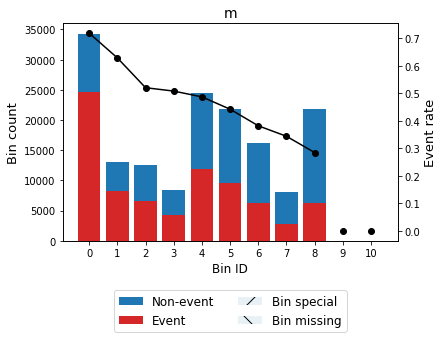

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.23340095
    IV (Jeffrey)             0.37618365
    JS (Jensen-Shannon)      0.04443499
    Hellinger                0.04567635
    Triangular               0.16890373
    KS                       0.23340095
    HHI                      0.67747306
    HHI (normalized)         0.56996408
    Cramer's V               0.29060603
    Quality score            0.42896923

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]     P[B > A]
        0      1 13571.583962      0.0       1.0 1.110223e-16



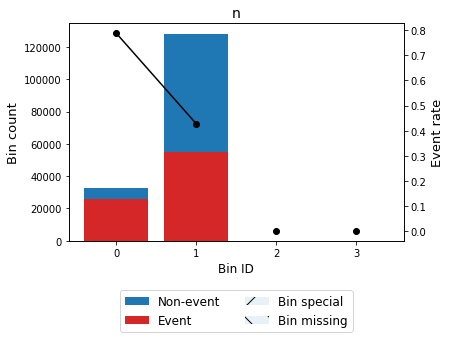

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.51211285
    IV (Jeffrey)             1.11576352
    JS (Jensen-Shannon)      0.12871541
    Hellinger                0.13377980
    Triangular               0.48040245
    KS                       0.45122027
    HHI                      0.39365150
    HHI (normalized)         0.24206438
    Cramer's V               0.49010328
    Quality score            0.06618842

  Monotonic trend        peak (concave)

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]     P[B > A]
        0      1 38100.593436      0.0       0.0 1.000000e+00
        1      2  7487.315150      0.0       1.0 1.110223e-16



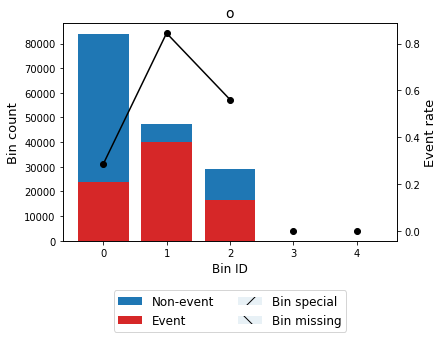

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.24852211
    IV (Jeffrey)             0.25583142
    JS (Jensen-Shannon)      0.03161699
    Hellinger                0.03179666
    Triangular               0.12506081
    KS                       0.24852211
    HHI                      0.50613433
    HHI (normalized)         0.34151245
    Cramer's V               0.25006080
    Quality score            0.56949567

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]     P[B > A]
        0      1 10048.760918      0.0       1.0 1.110223e-16



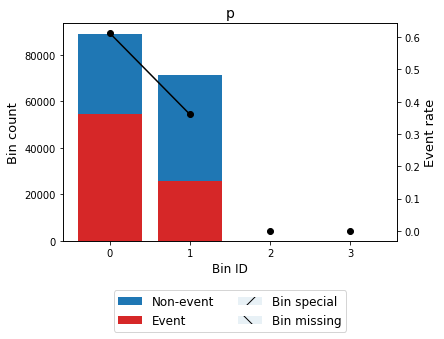

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.11436102
    IV (Jeffrey)             0.07727679
    JS (Jensen-Shannon)      0.00940112
    Hellinger                0.00952745
    Triangular               0.03665800
    KS                       0.04825080
    HHI                      0.14471108
    HHI (normalized)         0.07343700
    Cramer's V               0.13538463
    Quality score            0.01691791

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic       p-value     P[A > B]     P[B > A]
        0      1  1134.916868 8.511569e-249 1.000000e+00 1.110223e-16
        1      2    14.246819  1.603316e-04 9.999350e-01 6.500716e-05
        2      3    13.380675  2.542302e-04 9.999454e-01 5.462104e-05
        3      4    38.249168  6.226361e-10 4.547222e-12 1.000000e+00
        4      5     0.08190

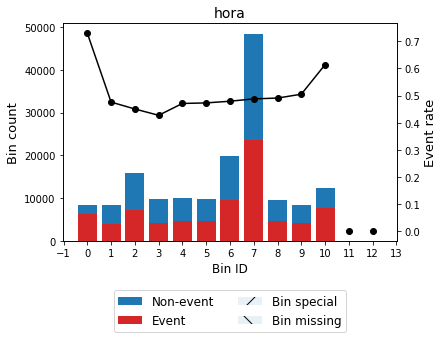

In [19]:
# using optbinning package

binning_process = BinningProcess(variable_names=X_train_OS_LE.columns.to_list())
X_train_OS_LE_BIN = binning_process.fit_transform(X_train_OS_LE, y_train_OS, metric="indices")

for col in X_train_OS_LE_BIN:
    __OpBinRes__ = binning_process.get_binned_variable(name=col)
    # __OpBinTable__ = __OpBinRes__.binning_table.build()
    __OpBinAnalysis__ = __OpBinRes__.binning_table.analysis()
    __OpBinPlot__ = __OpBinRes__.binning_table.plot(metric="event_rate")

    plt.show()

In [20]:
X_train_OS_LE_BIN.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,hora
0,1,4,6,1,2,1,1,3,3,3,4,4,5,0,0,0,10
1,0,2,2,4,0,5,0,2,2,2,0,11,4,1,0,1,7
2,1,5,1,4,0,4,1,4,3,0,4,11,2,1,0,0,0
3,1,3,3,4,0,1,1,2,3,0,5,3,4,1,1,1,10
4,1,4,5,2,0,0,1,2,2,4,4,1,1,0,0,0,7


In [21]:
# Correlation
correlation = pd.concat([y_train_OS, X_train_OS_LE_BIN], axis=1)
corr = correlation.corr()
corr.sort_values(YNAME, ascending=False, inplace=True)
corr.style.background_gradient(cmap='coolwarm')

,fraude,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,hora
fraude,1.000000,-0.121682,0.067548,-0.000561,-0.207474,-0.056920,-0.314491,0.067585,-0.122191,0.058822,-0.000628,0.012759,-0.302203,-0.285671,-0.290606,0.323001,-0.250061,0.002212
o,0.323001,-0.005612,0.019790,0.006778,-0.000988,-0.004688,-0.008962,0.018945,-0.018031,-0.004373,-0.003394,0.003854,-0.017989,-0.008875,0.034761,1.000000,0.026865,-0.002279
g,0.067585,0.081253,0.364599,-0.046747,-0.008201,0.099259,-0.080800,1.000000,-0.056664,-0.034005,-0.016008,0.003603,-0.055636,-0.054163,-0.022173,0.018945,-0.049888,-0.019566
b,0.067548,0.009610,1.000000,0.353228,-0.032527,-0.059945,-0.042884,0.364599,-0.096973,0.008908,-0.032533,-0.010077,-0.008748,-0.048374,-0.005087,0.019790,-0.036932,0.007384
i,0.058822,-0.025157,0.008908,0.032028,-0.019949,-0.066079,-0.035165,-0.034005,-0.027326,1.000000,-0.037632,-0.012918,-0.024984,-0.025059,-0.034655,-0.004373,-0.029352,0.011674
k,0.012759,0.003829,-0.010077,0.001318,0.005189,0.001057,-0.017856,0.003603,-0.005149,-0.012918,-0.001105,1.000000,-0.005361,0.004617,-0.007145,0.003854,0.011264,-0.002437
hora,0.002212,-0.038471,0.007384,-0.026184,-0.004495,-0.006312,-0.022593,-0.019566,-0.027921,0.011674,0.012798,-0.002437,-0.016341,-0.017731,-0.023758,-0.002279,-0.019024,1.000000
c,-0.000561,0.151028,0.353228,1.000000,0.028658,-0.034711,-0.060973,-0.046747,0.260364,0.032028,-0.050967,0.001318,-0.039789,0.026221,-0.018737,0.006778,0.013900,-0.026184
j,-0.000628,-0.046155,-0.032533,-0.050967,0.001752,0.000097,-0.009838,-0.016008,0.020379,-0.037632,1.000000,-0.001105,-0.020624,0.004306,-0.006945,-0.003394,0.005433,0.012798
e,-0.056920,0.261909,-0.059945,-0.034711,0.039205,1.000000,-0.067240,0.099259,0.150008,-0.066079,0.000097,0.001057,-0.049480,0.028206,-0.023582,-0.004688,0.002246,-0.006312


In [22]:
# drop feature  with more than 0.7 correlation
CORR_TRESHOLD = 0.7
correlated_drop = list()

__corr__ = corr.drop(columns=['fraude']).drop('fraude')

for col in __corr__:
    
    __CorrCol__ = __corr__[[col]]
    __correlated__ = __CorrCol__[(__CorrCol__[col] >= CORR_TRESHOLD) & (__CorrCol__[col] < 1)]

    __CorrList__ = __correlated__.index.to_list()

    if __CorrList__:
        __CorrY__ = corr[[YNAME]]

        __CorrY__ = __CorrY__.loc[__CorrList__ + [col],:].abs()

        __ColToDrop__ = [__CorrY__.loc[__CorrY__[YNAME] == __CorrY__[YNAME].min()].index[0]]

        correlated_drop = correlated_drop + __ColToDrop__


correlated_drop = list(set(correlated_drop))

print(f'The Columns {correlated_drop} will be delated because of high correlation with other features')



The Columns ['p', 'd'] will be delated because of high correlation with other features


In [23]:
X_train_Final = X_train_OS_LE_BIN.drop(columns=correlated_drop)

X_train_Final.head()

,a,b,c,e,f,g,h,i,j,k,l,m,n,o,hora
0,1,4,6,2,1,1,3,3,3,4,4,5,0,0,10
1,0,2,2,0,5,0,2,2,2,0,11,4,1,0,7
2,1,5,1,0,4,1,4,3,0,4,11,2,1,0,0
3,1,3,3,0,1,1,2,3,0,5,3,4,1,1,10
4,1,4,5,0,0,1,2,2,4,4,1,1,0,0,7


#### Apply same treatments to test and out of time sets

In [24]:
# Create 'hora' columns

X_test['hora'] = X_test['oper_date'].apply(lambda x: x.hour)
X_test.drop(columns=['oper_date'], inplace=True)

# replace missing data with -999 category
X_test_M = utils.replace_missing(X_test)
X_test_M.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,hora
36379,4,0.5901,206179.32,1.0,0.059345,1.0,BR,1,Kit 3 Máscaras Com Válvula Máxima Proteção Des...,cat_9eaf019,0.270425,4476.0,39.0,1,-999,N,20
24273,2,0.6546,3519.62,19.0,0.000000,10.0,AR,15,"Ropero Macizo Pino 1,20 C/tiradores",cat_e0e6611,0.895624,1403.0,281.0,1,N,Y,11
84806,4,0.7411,9869.07,3.0,0.000000,53.0,BR,0,Kit Alcance 1 Vitrificador Vx45 100ml+ 1 Lae36...,cat_a4032e6,0.320823,3712.0,73.0,1,-999,N,14
72731,4,-999.0000,-999.00,50.0,0.173548,56.0,BR,2,Crucis - Los Delirios Del Mariscal Lp Vinil Di...,cat_12a8b9b,0.015474,1782.0,1103.0,1,-999,Y,9
61554,4,0.7599,73246.35,5.0,0.499444,0.0,BR,8,Kit Quadros Decorativos Com Moldura Frases Mot...,cat_0c7e686,0.879819,23.0,23.0,0,-999,N,14


In [25]:

X_OutOfTime = outoftime.drop(columns=__colstodrop__)
y_OutOfTime = outoftime[[YNAME]]

# Create 'hora' columns
X_OutOfTime['hora'] = X_OutOfTime['oper_date'].apply(lambda x: x.hour)
X_OutOfTime.drop(columns=['oper_date'], inplace=True)

# replace missing data with -999 category
X_OutOfTime_M = utils.replace_missing(X_OutOfTime)
X_OutOfTime_M.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,hora
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1,Y,N,19
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1,-999,Y,16
8,4,0.5893,311762.23,6.0,0.000000,15.0,AR,2,Soldadora Inverter 180 A + Máscara + 2 Esc. Ma...,cat_bfe5d9b,0.897001,4661.0,826.0,1,Y,Y,22
11,4,0.7206,227874.02,1.0,0.230960,0.0,BR,8,Par Lanterna Luz De Placa C/ Led Fiat 500 Cone...,cat_768556e,0.530758,2640.0,0.0,1,-999,N,17
15,4,0.7072,171679.52,1.0,0.592092,101.0,AR,15,Canasto Organizador Ratan Plastico Mediano Tap...,cat_82dfc13,0.656695,5311.0,6.0,1,Y,N,17


In [26]:
# X_train_OS_LE = utils.encode_df(label_encoder, X_train_OS, FToTransf,'fit_transform')
X_test_M_LE = utils.encode_df(label_encoder, X_test_M, FToTransf, 'transform')
X_OutOfTime_M_LE = utils.encode_df(label_encoder, X_OutOfTime_M, FToTransf, 'transform')

In [27]:
X_test_M_LE_BIN = binning_process.transform(X_test_M_LE,  metric="indices")
X_OutOfTime_M_LE_BIN = binning_process.transform(X_OutOfTime_M_LE,  metric="indices")

In [28]:
X_test_Final = X_test_M_LE_BIN.drop(columns=correlated_drop)

X_test_Final.head()

,a,b,c,e,f,g,h,i,j,k,l,m,n,o,hora
0,1,2,6,0,1,1,1,0,1,1,11,2,1,0,8
1,0,3,2,0,4,0,3,0,4,5,6,5,1,1,4
2,1,4,2,0,6,1,0,0,2,2,11,3,1,0,6
3,1,0,0,2,6,1,2,0,0,0,7,8,1,0,2
4,1,4,5,5,0,1,3,2,0,5,1,2,0,0,6


In [29]:
X_OutOfTime_Final = X_OutOfTime_M_LE_BIN.drop(columns=correlated_drop)

X_OutOfTime_Final.head()

,a,b,c,e,f,g,h,i,j,k,l,m,n,o,hora
0,1,4,2,0,6,1,0,0,1,2,11,0,1,2,7
1,1,4,3,5,5,1,4,2,3,1,7,8,1,0,7
2,1,2,6,0,5,0,2,0,2,5,11,8,1,2,10
3,1,4,6,3,0,1,3,0,1,4,9,0,1,0,7
4,1,3,6,6,7,0,3,0,1,5,12,1,1,2,7


#### Train Models

In [30]:
NamesEstimators = [
    'lr',
    'dtc',
    'gbc',
    'rfc'
]

estimators = [
    LogisticRegression(random_state=SEED, n_jobs=-1),
    DecisionTreeClassifier(random_state=SEED),
    GradientBoostingClassifier(random_state=SEED),  
    RandomForestClassifier(random_state=SEED, n_jobs=-1),
]

GridParams = [
     {'C': np.logspace(-3,3,7), 'penalty':['l1','l2','elasticnet'], 'fit_intercept': [True, False] },
     {'max_depth':range(4, 11, 2), 'min_samples_split': np.logspace(-4,-1,5)},
     {'max_depth':range(4, 11, 2), 'min_samples_split': np.logspace(-4,-1,5), 'learning_rate': np.linspace(0.01, 0.2, 5),'max_features': [None, 'sqrt', 'log2']},
     {'max_depth':range(4, 11, 2), 'min_samples_split': np.logspace(-4,-1,5), 'n_estimators': np.arange(20,200, 20), 'max_features': [None, 'sqrt', 'log2']}
             ]

In [31]:
summary = pd.DataFrame()

for NameClf, clf, params in zip(NamesEstimators, estimators, GridParams):

    print('-'*10, 'Estimator', '-'*10)
    print(NameClf)
    print( '-'*40)

    GS = GridSearchCV(clf, param_grid=params, n_jobs=-1, cv=3, verbose=2, scoring='roc_auc')

    clf_best = GS.fit(X_train_Final, y_train_OS)
    score_test = clf_best.score(X_test_Final, y_test)
    score_outoftime = clf_best.score(X_OutOfTime_Final, y_OutOfTime)

    best_results = pd.DataFrame(clf_best.cv_results_)
    best_results.sort_values('rank_test_score', inplace=True)


    print(best_results[['mean_fit_time', 'params', 'mean_test_score' ]].head())
    print( '-'*40)
    print( '-'*10,'Score Test Set', '-'*10)
    print(score_test)
    print( '-'*10,'Score Out Of Time', '-'*10)
    print(score_outoftime)

    __summary__ = pd.DataFrame({
        'Estimator': NameClf, 
        'Best Params': str(clf_best.best_params_),
        'Best Score CV Train': clf_best.best_score_,
        'Score Test Set': score_test,
        'Score Out Of Time': score_outoftime
        }, index=[NameClf])

    summary = pd.concat([summary, __summary__])
#   
# print(cross_val_score(clf_best, X_train_Final, y_train_OS, cv=7, scoring='roc_auc'))
    # score = clf_best.score(X_test, y_test)
    
    # print("{} score: {}".format(name, score))

---------- Estimator ----------
lr
----------------------------------------
Fitting 3 folds for each of 42 candidates, totalling 126 fits
    mean_fit_time                                             params  \
13       3.601640  {'C': 0.1, 'fit_intercept': True, 'penalty': '...   
37       2.588844  {'C': 1000.0, 'fit_intercept': True, 'penalty'...   
19       3.217506  {'C': 1.0, 'fit_intercept': True, 'penalty': '...   
25       3.327427  {'C': 10.0, 'fit_intercept': True, 'penalty': ...   
31       3.440212  {'C': 100.0, 'fit_intercept': True, 'penalty':...   

    mean_test_score  
13         0.806651  
37         0.806651  
19         0.806650  
25         0.806650  
31         0.806650  
----------------------------------------
---------- Score Test Set ----------
0.8080413097479333
---------- Score Out Of Time ----------
0.8006934322123203
---------- Estimator ----------
dtc
----------------------------------------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
   

In [32]:
summary['Mean_Score_Test_OFT'] = summary[['Score Test Set', 'Score Out Of Time']].apply(lambda x: x.mean(), axis=1)
summary['Diff_train_test'] = summary['Best Score CV Train'] - summary['Mean_Score_Test_OFT']
summary['Quality_Model'] = summary['Mean_Score_Test_OFT'] / summary['Diff_train_test']
summary

,Estimator,Best Params,Best Score CV Train,Score Test Set,Score Out Of Time,Mean_Score_Test_OFT,Diff_train_test,Quality_Model
lr,lr,"{'C': 0.1, 'fit_intercept': True, 'penalty': '...",0.806651,0.808041,0.800693,0.804367,0.002284,352.243405
dtc,dtc,"{'max_depth': 10, 'min_samples_split': 0.0001}",0.881654,0.704250,0.717881,0.711066,0.170588,4.168316
gbc,gbc,"{'learning_rate': 0.2, 'max_depth': 10, 'max_f...",0.997374,0.717524,0.717622,0.717573,0.279801,2.564581
rfc,rfc,"{'max_depth': 10, 'max_features': None, 'min_s...",0.907201,0.810301,0.802800,0.806550,0.100651,8.013352


In [33]:
best_estimator = summary[summary['Quality_Model'] == summary['Quality_Model'].max()]
best_params = eval(best_estimator['Best Params'].values[0])

#### Final Model

In [34]:
clf = utils.LogisticReg(random_state=SEED, n_jobs=-1, **best_params)
clf.fit(X_train_Final, y_train_OS)

# Scorecard
pd.options.display.float_format = '{:,.5f}'.format

scorecard = pd.DataFrame({'Variables':X_train_Final.columns,
                                      'Coefficients': clf.model.coef_[0], 
                                      'p-values': clf.p_values}).sort_values('Coefficients', ascending=False)
scorecard

,Variables,Coefficients,p-values
13,o,1.02098,0.00000
5,g,0.24331,0.00000
7,i,0.13257,0.00000
1,b,0.02991,0.00000
9,k,0.01423,0.00001
2,c,0.01387,0.00000
8,j,-0.00288,0.48651
14,hora,-0.01298,0.00000
3,e,-0.04347,0.00000
10,l,-0.07825,0.00000


In [35]:
# Variable 'j' has a p-value > 0.05 and will be removed from the model

NonSigVars = scorecard[scorecard['p-values'] > 0.05].Variables.to_list()
print(NonSigVars)

X_train_Final.drop(columns=NonSigVars, inplace=True)
X_test_Final.drop(columns=NonSigVars, inplace=True)
X_OutOfTime_Final.drop(columns=NonSigVars, inplace=True)

['j']


In [36]:
# Try the model again

clf = utils.LogisticReg(random_state=SEED, n_jobs=-1, **best_params)
clf.fit(X_train_Final, y_train_OS)

# Scorecard
pd.options.display.float_format = '{:,.5f}'.format

scorecard = pd.DataFrame({'Variables':X_train_Final.columns,
                                      'Coefficients': clf.model.coef_[0], 
                                      'p-values': clf.p_values}).sort_values('Coefficients', ascending=False)
scorecard

,Variables,Coefficients,p-values
12,o,1.02097,0.00000
5,g,0.24348,0.00000
7,i,0.13312,0.00000
1,b,0.03004,0.00000
8,k,0.01429,0.00000
2,c,0.01394,0.00000
13,hora,-0.01296,0.00000
3,e,-0.04341,0.00000
9,l,-0.07817,0.00000
4,f,-0.12234,0.00000


In [37]:
# Score Model

y_test_pred_prob  = clf.model.predict_proba(X_test_Final)[:,1]
y_OFT_pred_prob = clf.model.predict_proba(X_OutOfTime_Final)[:,1]

#### Evaluation

****************************************
---------- AUC Scores-AUC Scores-AUC Scores-AUC Scores-AUC Scores-AUC Scores-AUC Scores-AUC Scores-AUC Scores-AUC Scores-
Naive: 0.5
Model: 0.8080325081545656
Challenger: 0.7271163152624789


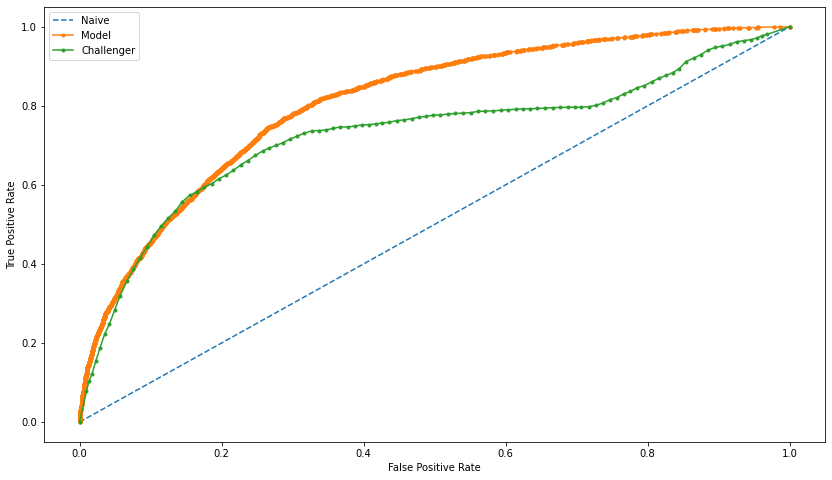

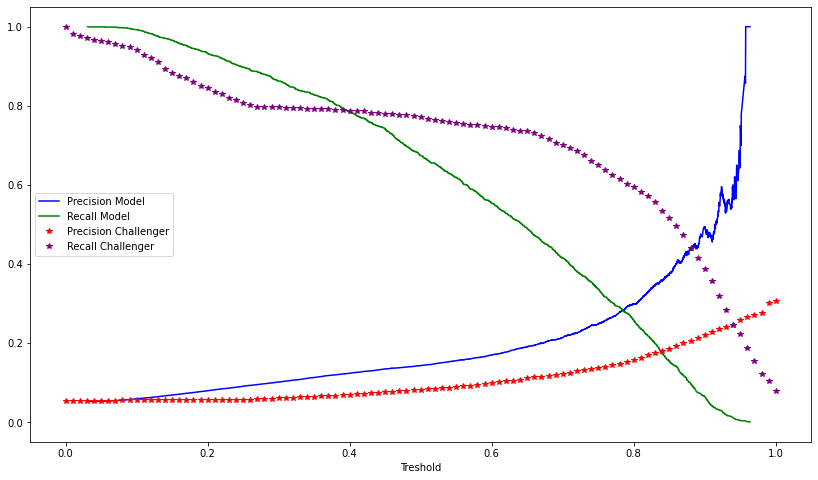

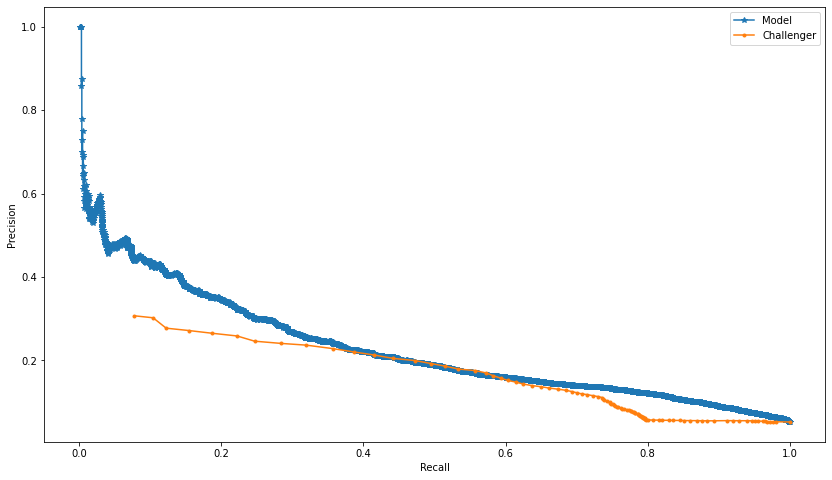

In [38]:
meli_prob_test = traintest['score'][y_test.index.to_list()].values/100
utils.evaluate_model(y_test, y_test_pred_prob, meli_prob_test)

****************************************
---------- AUC Scores-AUC Scores-AUC Scores-AUC Scores-AUC Scores-AUC Scores-AUC Scores-AUC Scores-AUC Scores-AUC Scores-
Naive: 0.5
Model: 0.8006663450165266
Challenger: 0.7277226226902962


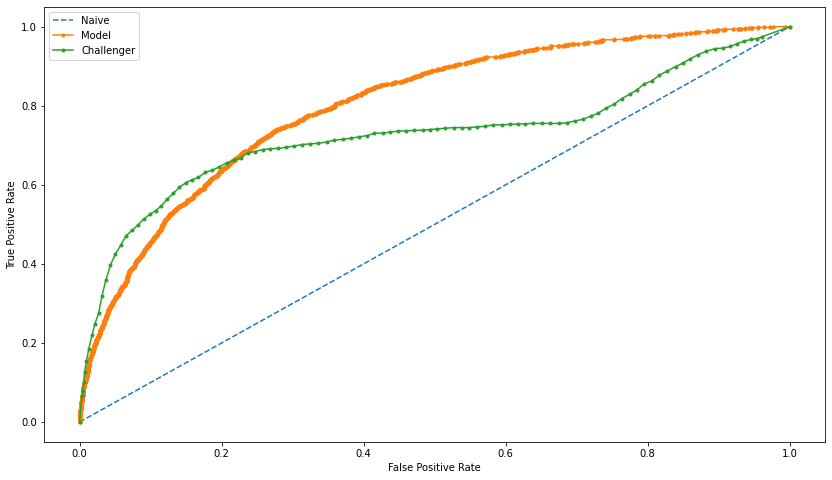

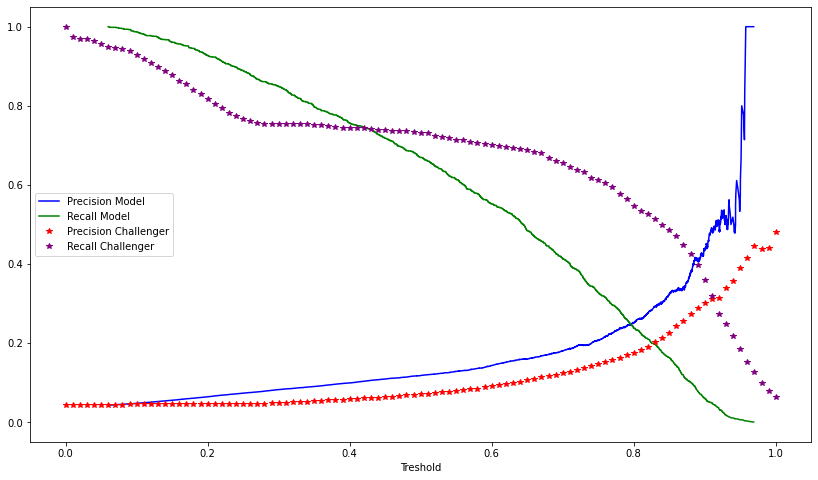

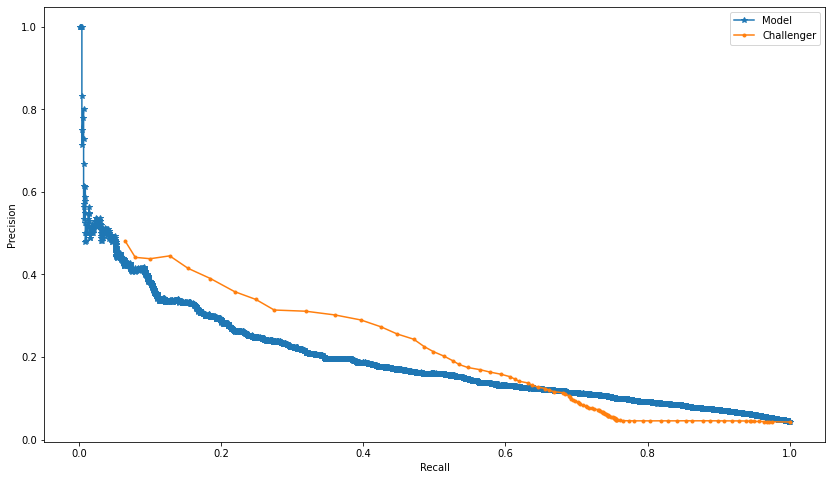

In [39]:
meli_prob_OutOfTime = outoftime['score']/100
utils.evaluate_model(y_OutOfTime, y_OFT_pred_prob, meli_prob_OutOfTime)

#### Set Treshold

* For this problem its better focus on Recall than Precision because the cost of classify a Fraud as Non Fraud is Higher than classify a Non Fraud as a Fraud
* But Classify, let say half the transactions as fraud and block the transaction does not give a better user experience
* I will then optmize the treshold considering that for every Non Fraud that the model correctly predicted Meli will profit 10% and for every fraud that the model predicts as non fraud Meli will Lose 100%. For every Fraud correctly predicted and for every non fraud predicted as fraud the profit or cost is zero.
* The formula then is:
* profit = 0.1*True Negatives - False Negative

In [40]:
# Find Best Treshold for the model
range_treshold = range(0,1005,5)
margin = 0.10
cost = 1


best_treshold_test = utils.define_treshold(y_test, y_test_pred_prob, margin, cost, range_treshold)['best_tresholds']

MODEL_TRESHOLD = best_treshold_test[best_treshold_test['Criteria'] == 'best_profit_precision_recall'].index[0]

print(f'MODEL_TRESHOLD {MODEL_TRESHOLD}')
print()

y_pred_test = [1 if x >= MODEL_TRESHOLD else 0 for x in y_test_pred_prob]
y_pred_OFT = [1 if x >= MODEL_TRESHOLD else 0 for x in y_OFT_pred_prob] 

print('AUC Test: ', roc_auc_score(y_test, y_pred_test))
print('AUC Out Of Time: ',roc_auc_score(y_OutOfTime, y_pred_OFT))

best_treshold_test


MODEL_TRESHOLD 0.42

AUC Test:  0.7402428574115615
AUC Out Of Time:  0.7288329211693612


,treshold,ExpectedProfit,precision,recall,TrueNegatives,FalsePositives,FalseNegatives,TruePositives,profit_precision,profit_recall,profit_precision_recall,Criteria
0.64000,0.64000,"2,079.70000",0.18715,0.50473,30227,4174,943,961,389.20968,"1,049.68051",719.44510,best_profit
0.03000,0.03000,0.30000,0.05245,1.00000,3,34398,0,1904,0.01573,0.30000,0.15787,best_recall
0.96000,0.96000,"1,538.10000",1.00000,0.00105,34401,0,1902,2,"1,538.10000",1.61565,769.85783,best_precision
0.96000,0.96000,"1,538.10000",1.00000,0.00105,34401,0,1902,2,"1,538.10000",1.61565,769.85783,best_profit_precision
0.36500,0.36500,"1,918.80000",0.11700,0.81933,22628,11773,344,1560,224.50521,"1,572.12605",898.31563,best_profit_recall
0.42000,0.42000,"2,007.90000",0.12858,0.76891,24479,9922,440,1464,258.17369,"1,543.88950",901.03159,best_profit_precision_recall


In [41]:
# Find Best Treshold for MELI model
range_treshold = range(0,1005,5)
margin = 0.10
cost = 1


best_treshold_meli_test = utils.define_treshold(y_test, meli_prob_test, margin, cost, range_treshold)['best_tresholds']

MELI_TRESHOLD = best_treshold_meli_test[best_treshold_meli_test['Criteria'] == 'best_profit_precision_recall'].index[0]

print(f'MODEL_TRESHOLD {MELI_TRESHOLD}')
print()

y_pred_meli_test = [1 if x >= MELI_TRESHOLD else 0 for x in meli_prob_test]
y_pred_meli_OFT = [1 if x >= MELI_TRESHOLD else 0 for x in meli_prob_OutOfTime] 

print('AUC Test: ', roc_auc_score(y_test, y_pred_meli_test))
print('AUC Out Of Time: ',roc_auc_score(y_OutOfTime, y_pred_meli_OFT))

best_treshold_meli_test


MODEL_TRESHOLD 0.72

AUC Test:  0.7138806501496561
AUC Out Of Time:  0.7250848159631001


,treshold,ExpectedProfit,precision,recall,TrueNegatives,FalsePositives,FalseNegatives,TruePositives,profit_precision,profit_recall,profit_precision_recall,Criteria
0.82500,0.82500,"2,099.50000",0.17590,0.55672,29435,4966,844,1060,369.31132,"1,168.83929",769.07530,best_profit
0.00500,0.00500,72.60000,0.05308,0.98057,1096,33305,37,1867,3.85375,71.18918,37.52147,best_recall
1.00000,1.00000,"1,650.70000",0.30705,0.07773,34067,334,1756,148,506.85394,128.31071,317.58233,best_precision
0.99000,0.99000,"1,688.40000",0.30229,0.10399,33944,457,1706,198,510.38656,175.57941,342.98299,best_profit_precision
0.68000,0.68000,"1,880.20000",0.11801,0.71534,24222,10179,542,1362,221.88999,"1,344.97500",783.43250,best_profit_recall
0.72000,0.72000,"1,954.80000",0.12834,0.68540,25538,8863,599,1305,250.88651,"1,339.81828",795.35239,best_profit_precision_recall
